In [1]:
# Run if you are on Google Colab to install the Python bindings
!bash compile.sh

running build_ext
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include/python3.6m -c flagcheck.cpp -o flagcheck.o -std=c++17
building 'screening' extension
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -DVERSION_INFO=0.0.1 -I/Users/wonjunlee/miniconda3/envs/cv/lib/python3.6/site-packages/pybind11/include -I/Users/wonjunlee/miniconda3/envs/cv/include/python3.6m -c src/main.cpp -o build/temp.macosx-10.9-x86_64-3.6/src/main.o -std=c++17 -mmacosx-version-min=10.14 -fvisibility=hidden -g0 -stdlib=libc++
src/main.cpp:208:13: warning: unused variable 'psi' [-Wunused-variable]
    double *psi = static_ca

In [2]:
import argparse
import os
import numpy as np
import math
import sys
import copy
import matplotlib.pyplot as plt
from screening import HelperClass

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch

cuda = True if torch.cuda.is_available() else False
os.makedirs("images", exist_ok=True)

# Importing functions (Poisson solver, finite difference schemes, c-transform, etc)

In [3]:
from python_functions.poisson_helper import *
from python_functions.finite_diff_helper import *
from screening import c_transform_cpp, c_transform_forward_cpp , approx_push_cpp, c_transform_epsilon_cpp, compute_nu_and_rho_cpp, compute_xi_cpp

In [4]:
import os
import numpy as np
from scipy.fftpack import dctn, idctn
import math
import sys
import copy

# Initialize Fourier kernel
def initialize_kernel(n1, n2, dy):
    xx, yy = np.meshgrid(np.linspace(0,np.pi,n1,False), np.linspace(0,np.pi,n2,False))
    # kernel = 2*n1*n1*(1-np.cos(xx)) + 2*n2*n2*(1-np.cos(yy))
    kernel = 2*(1-np.cos(xx))/(dy*dy) + 2*(1-np.cos(yy))/(dy*dy)
    kernel[0,0] = 1     # to avoid dividing by zero
    return kernel

# 2d DCT
def dct2(a):
    return dctn(a, norm='ortho')

# 2d IDCT
def idct2(a):
    return idctn(a, norm='ortho')

# Solving Poisson
#   - Δ u = f
#   output: u = (-Δ)⁻¹ f
def solve_poisson(u, f, kernel):
    n = u.shape[0]
    u[:] = 0
    workspace = np.copy(f)
    workspace = dct2(workspace) / kernel
    workspace[0,0] = 0
    u += idct2(workspace)

def solve_poisson_bdry(u, f, bdry, kernel):
    gx0, gx1, gy0, gy1 = bdry
    n = u.shape[0]
    u[:] = 0
    workspace = np.copy(f)
    workspace[0,:]   -= gy0 * n
    workspace[n-1,:] += gy1 * n
    workspace[:,0]   -= gx0 * n
    workspace[:,n-1] += gx1 * n
    workspace = dct2(workspace) / kernel
    workspace[0,0] = 0
    u += idct2(workspace)

# Defining functions

In [5]:
# performing c transform
# output: modified psi
def c_transform(psi, phi, cost):
  n,m = psi.shape[0], phi.shape[0]
  psi[:] = torch.min(cost + phi.view((1,m*m)), dim=1).values.view((n,n))
  

def c_transform_forward(phi, psi, cost):
  N = psi.shape[0]
  phi[:] = np.max(- cost + psi.reshape((N,1)), axis=0)

# push forward
def approx_push(nu, psi, phi, cost, epsilon: float, dx: float, dy: float, yMax: float):
  n = psi.shape[0]
  m = phi.shape[0]
  mat   = torch.exp((psi.view((n*n,1)) - phi.view((1,m*m)) - cost) / epsilon) # mat = (n*n, n*n) matrix
  mat  /= torch.sum(mat, dim=1).view((n*n,1)) * (dy*dy)
  nu[:] = torch.sum(mat, dim=0).view((m,m)) * (dx*dx)


def compute_rhs(phi_np, psi_np, nu_np, b, helper, dx, dy, show_image=False):
  n = phi_np.shape[0]
  tmp = np.zeros((n+2,n+2))
  #   initialize fx, fy
  fx = np.zeros((n, n))
  fy = np.zeros((n, n))

  phi_b = phi_np-b
  compute_dx(fx, phi_b, dy)
  compute_dy(fy, phi_b, dy)

#   det = phixx * phiyy - phixy * phixy
#   R1 = nu_np * (  phiyy * fx - phixy * fy) / det
#   R2 = nu_np * (- phixy * fx + phixx * fy) / det

  R1  = np.zeros((n,n))
  R2  = np.zeros((n,n))
  R1x = np.zeros((n,n))
  R2y = np.zeros((n,n))

  helper.compute_inverse_g(R1, R2, phi_np, psi_np, fx, fy)

  R1_nu = nu_np * R1
  R2_nu = nu_np * R2

  # R1x = compute_dx_forward(R1, tmp, dy)
  # R2y = compute_dy_forward(R2, tmp, dy)

  compute_dx(R1x, R1_nu, dy)
  compute_dy(R2y, R2_nu, dy)

  gx0 = -R1_nu[:,0]
  gx1 = -R1_nu[:,-1]

  gy0 = -R2_nu[0,:]
  gy1 = -R2_nu[-1,:]

  # fig,ax = plt.subplots(1,5,figsize=(17,4))
  # ax[0].imshow(R1_nu,origin='lower')
  # ax[0].set_title("R1")
  # ax[1].imshow(R2_nu,origin='lower')
  # ax[1].set_title("R2")
  # ax[2].imshow(R1x,origin='lower')
  # ax[2].set_title("R1x")
  # ax[3].imshow(R2y,origin='lower')
  # ax[3].set_title("R2y")
  # ax[4].imshow(nu_np,origin='lower')
  # ax[4].set_title("nu_np")
  # plt.show()

  return nu_np + R1x + R2y, [gx0,gx1,gy0,gy1], R1, R2, R1x, R2y


def solve_poisson(u, phi_np, psi_np, nu_np, b, kernel, helper, dx, dy, yMax, show_image=False):
  rhs, bdry, R1, R2, R1x, R2y = compute_rhs(phi_np, psi_np, nu_np, b, helper, dx, dy, show_image=show_image) # computing the right hand side
  solve_poisson_bdry(u,rhs,bdry,kernel)
  return rhs, R1, R2, R1x, R2y

In [6]:
# centered difference
def compute_dx(output, phi, dy):
  m = int(np.sqrt(phi.shape[0]))
  phi = phi.reshape((m,m))
  output[:,1:-1] = (phi[:,2:] - phi[:,:-2])/(2.0*dy)
  output[:,0]    = (phi[:,1] - phi[:,0])/(1.0*dy)
  output[:,-1]   = (phi[:,-1] - phi[:,-2])/(1.0*dy)

# centered difference
def compute_dy(output, phi, dy):
  m = int(np.sqrt(phi.shape[0]))
  phi = phi.reshape((m,m))
  output[1:-1,:] = (phi[2:,:] - phi[:-2,:])/(2.0*dy)
  output[0,:]    = (phi[1,:] - phi[0,:])/(1.0*dy)
  output[-1,:]   = (phi[-1,:] - phi[-2,:])/(1.0*dy)

size of cost:  (1600, 3600)


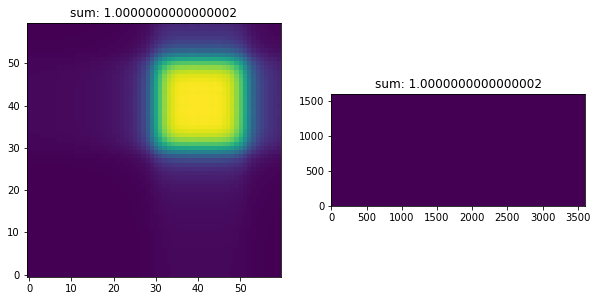

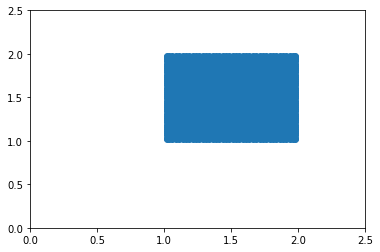

In [58]:
from IPython import display

# parameters
# grid size n x n
n = 40
m = 60

# step size for the gradient ascent
L = 5000

# epsilon for pushforward
eps = 1e-2
max_iteration = 10000000

Xx,Xy = np.meshgrid(np.linspace(1+0.5/n,2-0.5/n,n), np.linspace(1+0.5/n,2-0.5/n,n))
yMax = 2
Yx,Yy = np.meshgrid(np.linspace(0.5/m,1-0.5/m,m), np.linspace(0.5/m,1-0.5/m,m))
Yx = Yx*2.0
Yy = Yy*2.0

dx = 1.0/n
dy = dx * yMax

# kernel = initialize_kernel(n, n, dy)
kernel = initialize_kernel(n, n, 1.0/n*yMax)

Xv = np.zeros((n*n,2))
Xv[:,0] = Xx.reshape((n*n,))
Xv[:,1] = Xy.reshape((n*n,))

Yv = np.zeros((m*m,2))
Yv[:,0] = Yx.reshape((m*m,))
Yv[:,1] = Yy.reshape((m*m,))

cost_np = - np.sum(Xv.reshape((n*n,1,2)) * Yv.reshape((1,m*m,2)),axis=2)

print("size of cost: ", cost_np.shape)
b_np       = 0.5 * (Yx**2 + Yy**2)
b_np     = b_np.flatten()
psi_np     = - 0.5 * (Xx**2+Xy**2)
psi_np     = psi_np.flatten()
phi_np     = np.zeros((m*m)).astype('float64')
nu_np      = np.zeros((m*m)).astype('float64')
psi_eps_np = np.zeros((n*n)).astype('float64')
rho_np     = np.zeros((m*m)).astype('float64')



# phi  = torch.from_numpy(phi).type(torch.float32)
cost = torch.from_numpy(cost_np)
phi  = torch.from_numpy(phi_np)
psi  = torch.from_numpy(psi_np)
nu   = torch.from_numpy(nu_np)

# c_transform_forward(phi_np, psi_np, cost_np)
c_transform_forward_cpp(phi_np, psi_np, cost_np)

fig,ax = plt.subplots(1,2,figsize=(10,5))

# c_transform_epsilon_cpp(psi_eps_np, psi_np, phi_np, cost_np, eps, dx, dy, yMax)
# compute_nu_and_rho_cpp(nu_np, rho_np, psi_eps_np, phi_np,  cost_np, b_np, epsilon, dx, dy, yMax)

def compute_ctransform_eps(psi_eps_np, phi_np, cost_np, eps, dy):
  psi_eps_np[:] = (np.exp( (-phi_np.reshape((1,-1)) - cost_np)/eps ) * dy*dy).sum(axis=1)
  psi_eps_np[:] = - eps * np.log(psi_eps_np)

compute_ctransform_eps(psi_eps_np, phi_np, cost_np, eps, dy)
plan = np.exp( (psi_eps_np.reshape((n*n,1)) - phi_np.reshape((1,m*m)) - cost_np)/eps ) * dx*dx * dy*dy
nu_np[:] = plan.sum(axis=0)
ax[0].imshow(nu_np.reshape((m,m)), origin='lower')
ax[0].set_title(f'sum: {np.sum(nu_np)}')
plan[plan!=0] = 1
ax[1].imshow(plan, origin='lower')
ax[1].set_title(f'sum: {np.sum(nu_np)}')

plt.show()

helper = HelperClass(psi, phi, dx, dy)

u = np.zeros((n,n))

Tx = np.zeros((n,n))
Ty = np.zeros((n,n))
compute_dx(Tx, psi_np, dx)
compute_dy(Ty, psi_np, dx)
Tx = - Tx
Ty = - Ty

plt.figure()
plt.scatter(Tx,Ty)
plt.xlim([0,2.5])
plt.ylim([0,2.5])
plt.show()

if cuda:
  phi  = phi.cuda()
  psi  = psi.cuda()
  cost = cost.cuda()
  nu   = nu.cuda()

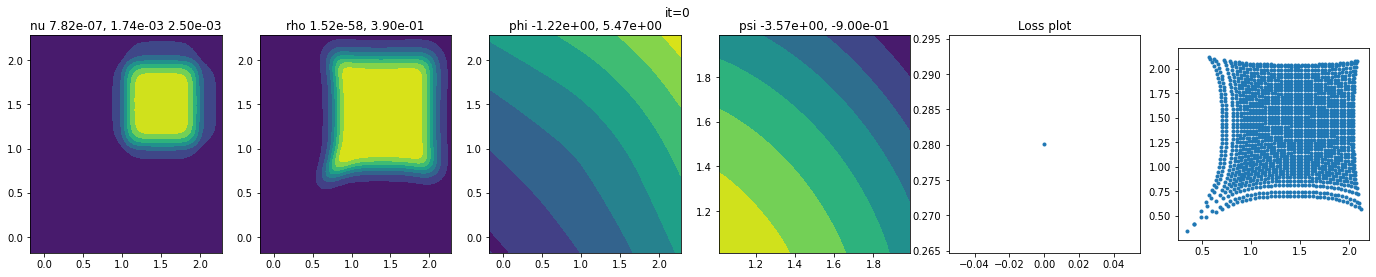

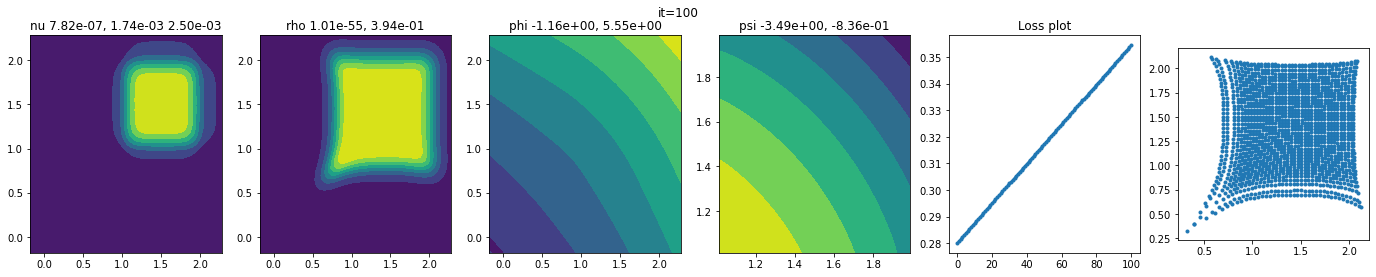

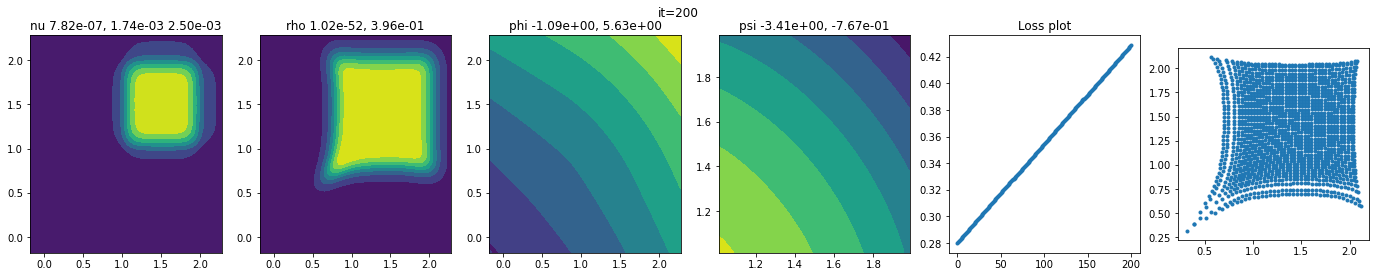

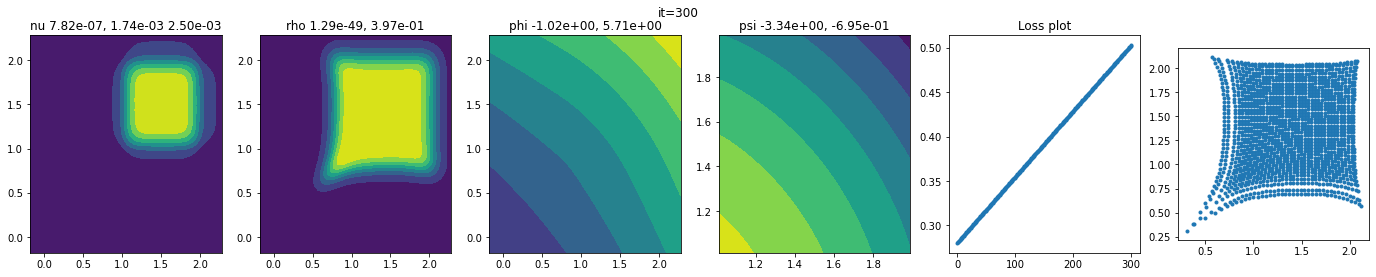

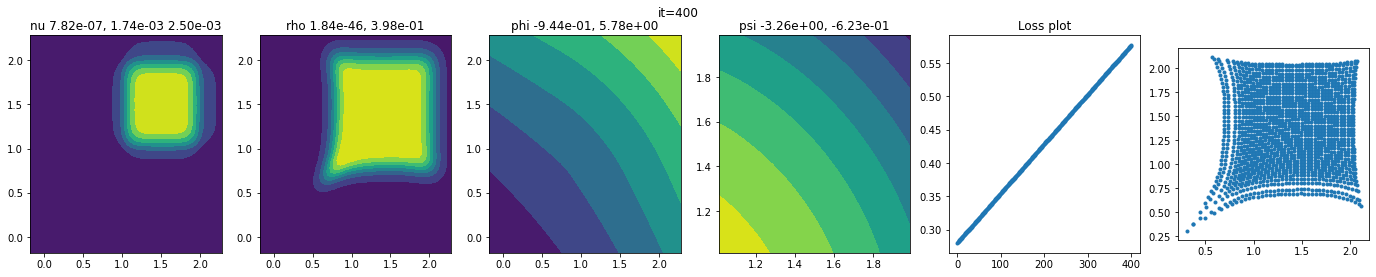

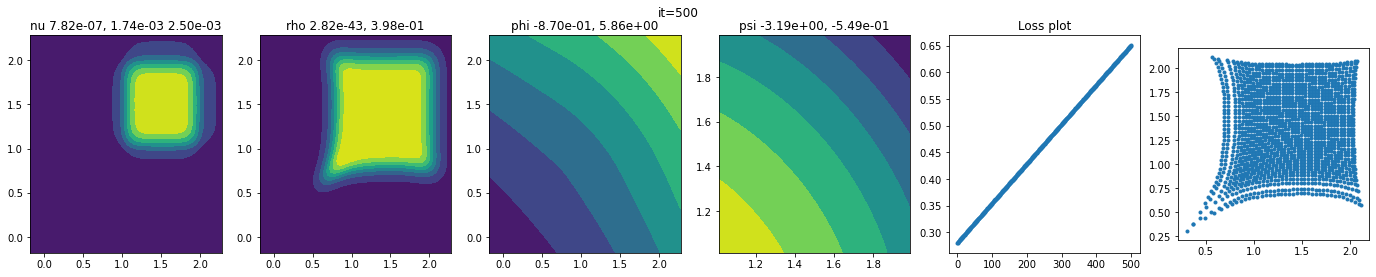

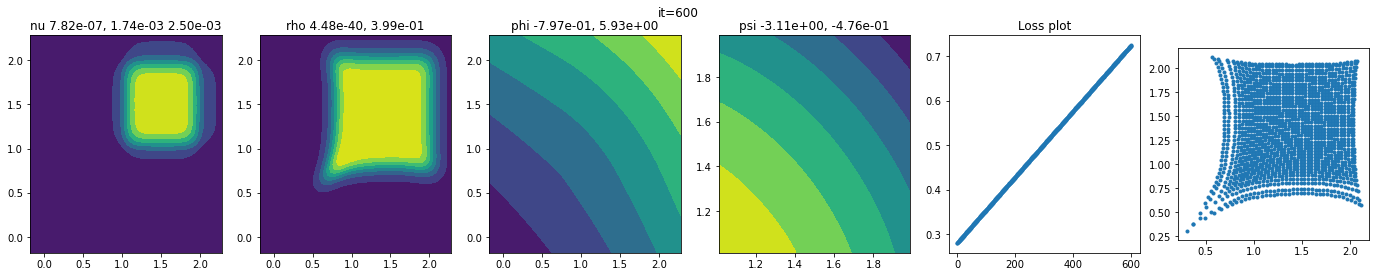

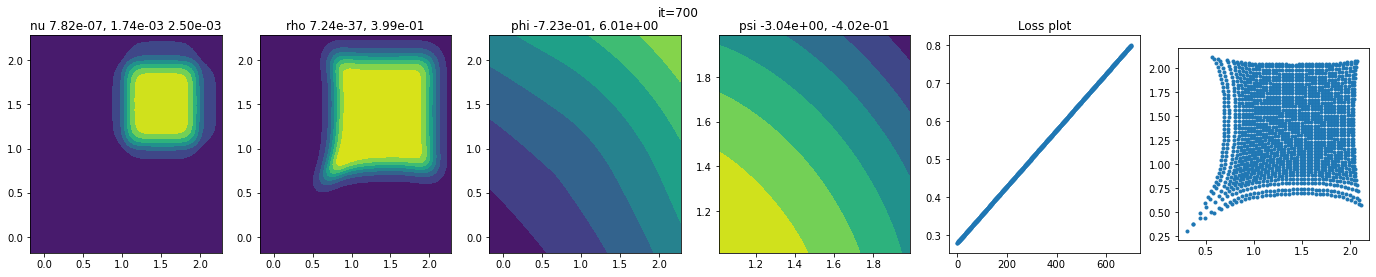

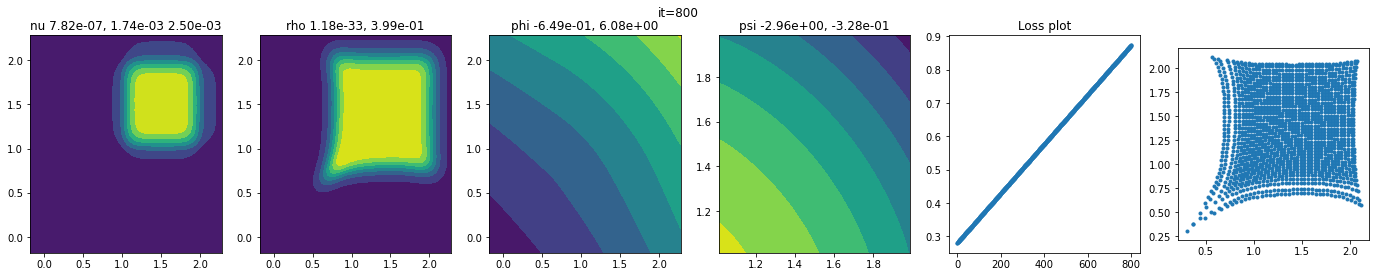

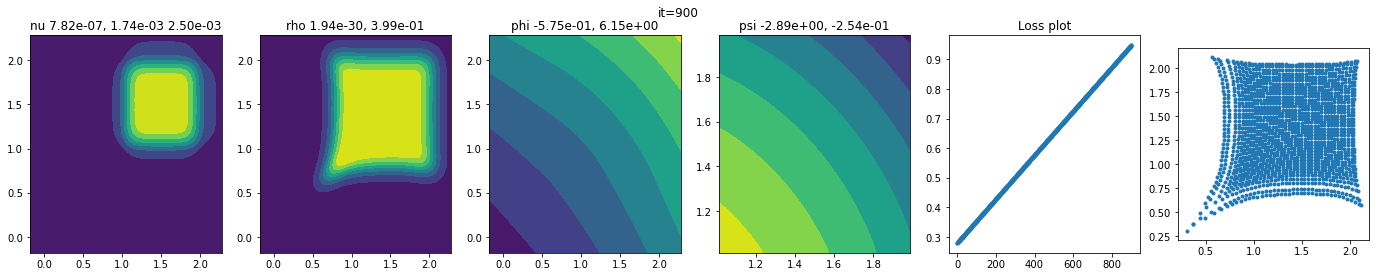

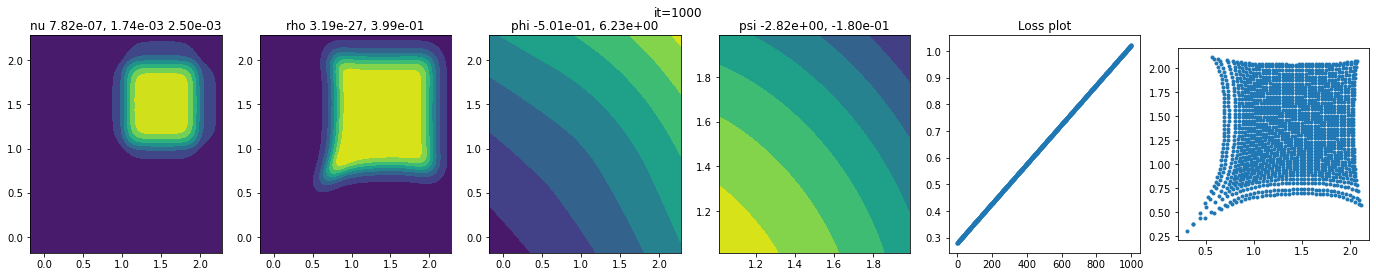

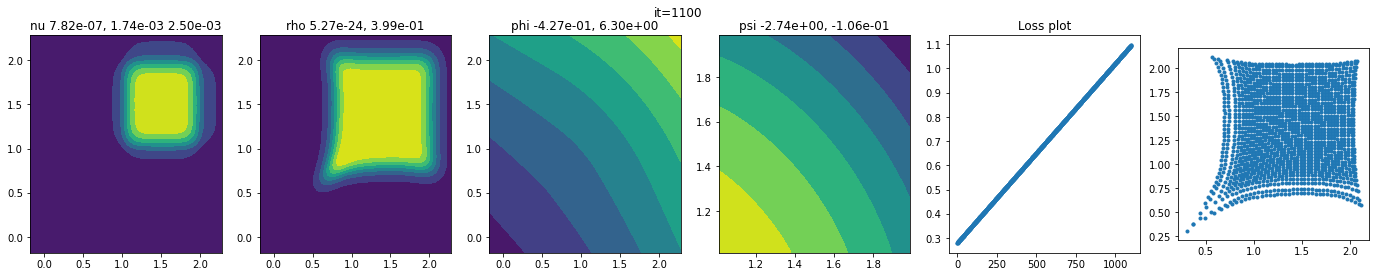

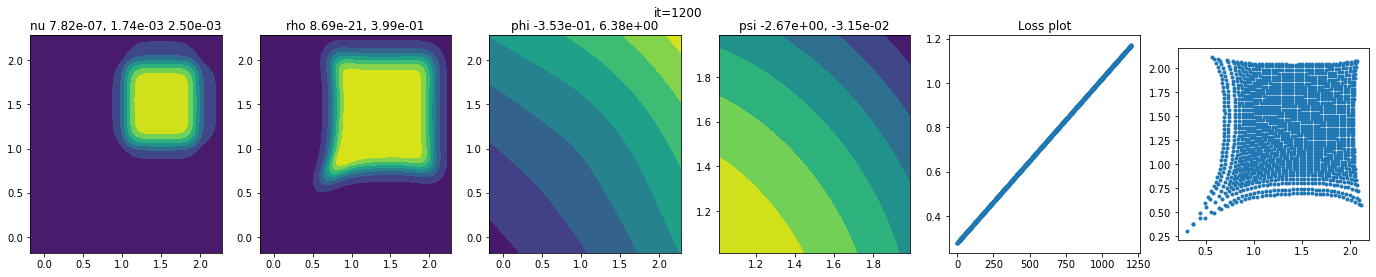

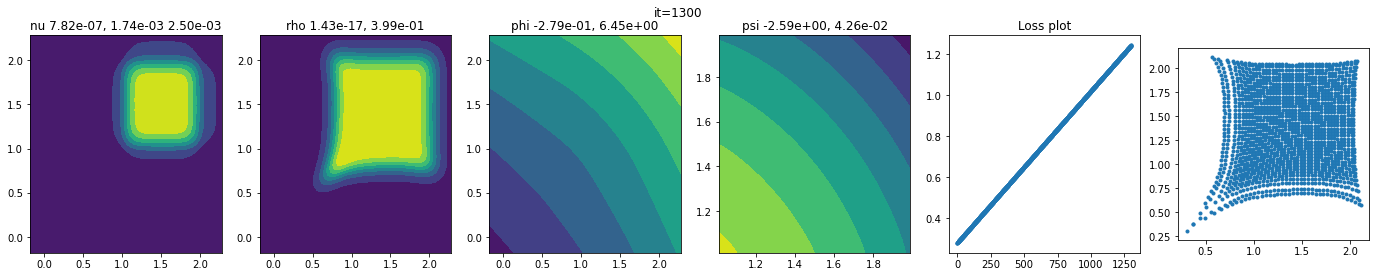

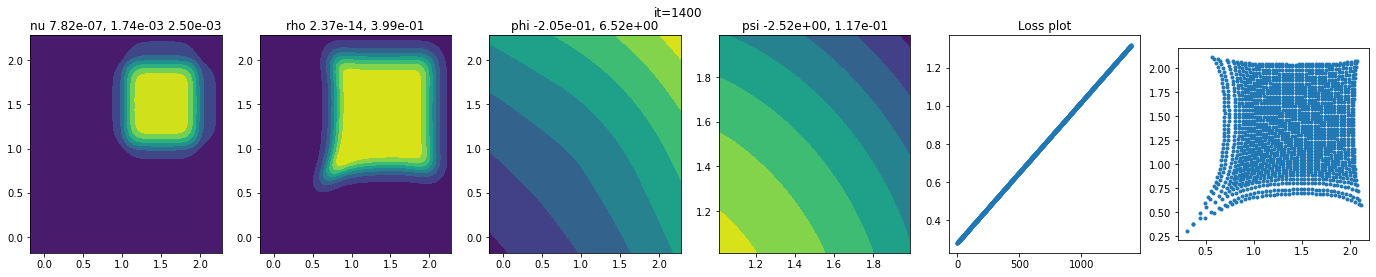

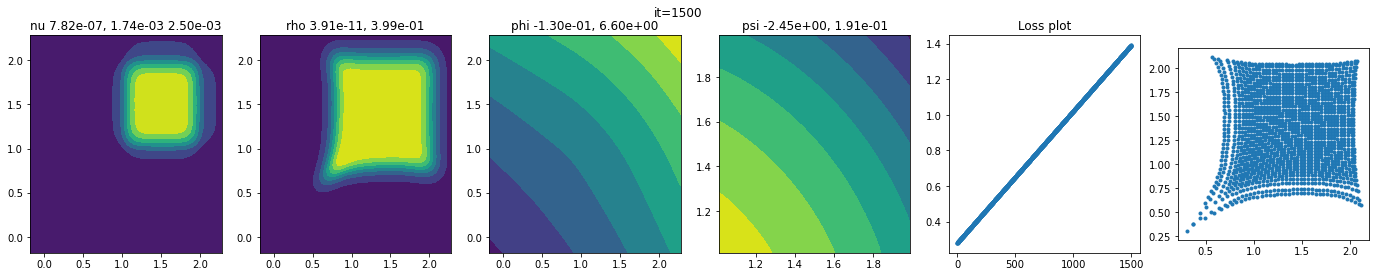

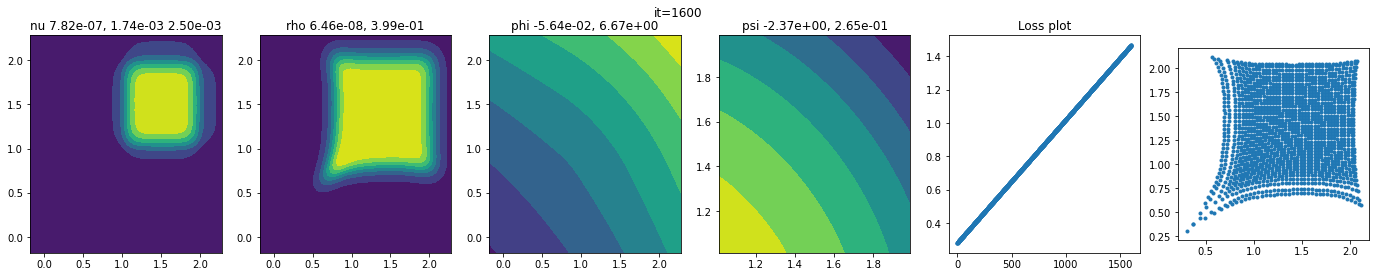

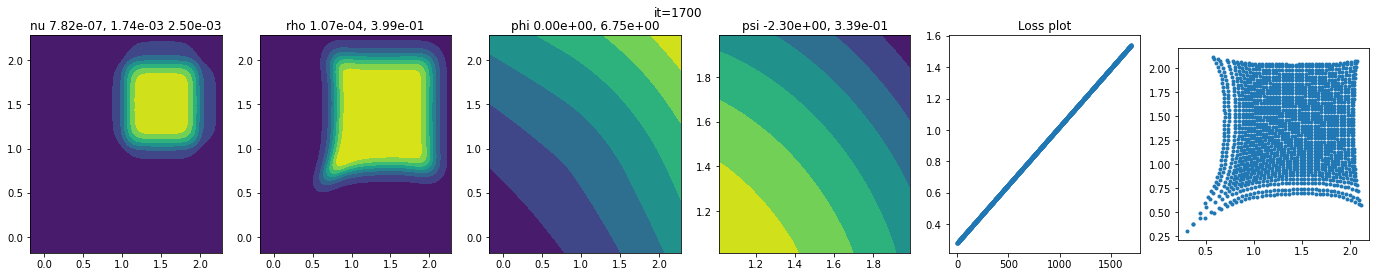

KeyboardInterrupt: 

In [60]:
# fig,ax = plt.subplots(1,5,figsize=(18,4))
# hdisplay = display.display("", display_id=True)

J_list = []
L = 150
eps = 1e-2

for it in range(max_iteration):
  # c_transform(psi, phi, cost)
  c_transform_epsilon_cpp(psi_eps_np, psi_np, phi_np, cost_np, eps, dx, dy, yMax)

  # compute plan
  # compute_ctransform_eps(psi_eps_np, phi_np, cost_np, eps, dy)
  plan = np.exp( (psi_eps_np.reshape((-1,1)) - phi_np.reshape((1,-1)) - cost_np)/eps )

  rho_np[:] = plan.sum(axis=0) * dx*dx

  

  b_phi = (phi_np - b_np)/eps
  xi = plan @ b_phi.reshape((-1,1)) * dy*dy

  phi_np += 1.0/L * ( (1.0 - b_phi)*rho_np + (xi.reshape((1,-1))@plan).flatten() * dx * dx )  
  phi_np[0] = 0 # outside option

  # plan = np.exp( (psi_eps_np.reshape((-1,1)) - phi_np.reshape((1,-1)) - cost_np)/eps )
  # nu_np[:] = plan.sum(axis=0) * dx * dx
  # print("rho:",nu_np.sum()*dy*dy)
  # compute_xi_cpp(nu_np, rho_np, psi_eps_np, phi_np,  cost_np, b_np, plan, eps, dx, dy, yMax)

  # # gradient ascent
  # phi_np += 1.0/L * ((1.0 - (b_np-phi_np)/eps) * nu_np + rho_np)
  # phi[0] = 0 # outside option
  
  
  J_val = ((phi_np - b_np) * rho_np).sum() * dy*dy
  J_list.append(J_val)

  
  # for plotting point cloud version of T(x)
  compute_dx(Tx, psi_eps_np, dx)
  compute_dy(Ty, psi_eps_np, dx)

  Tx = -Tx; Ty = -Ty

  if it % 100 == 0:
    fig,ax = plt.subplots(1,6,figsize=(24,4))
    ax[0].contourf(Yx,Yy,nu_np.reshape(m,m))
    ax[0].set_title(f"nu {np.min(nu_np):0.2e}, {np.max(nu_np):0.2e} {np.sum(nu_np)*dy**2:0.2e}")
    ax[1].contourf(Yx,Yy,rho_np.reshape(m,m))
    ax[1].set_title(f"rho {np.min(rho_np):0.2e}, {np.max(rho_np):0.2e}")
    ax[2].contourf(Yx,Yy,phi_np.reshape(m,m))
    ax[2].set_title(f"phi {np.min(phi_np):0.2e}, {np.max(phi_np):0.2e}")
    ax[3].contourf(Xx,Xy,psi_eps_np.reshape(n,n))
    ax[3].set_title(f"psi {np.min(psi_eps_np):0.2e}, {np.max(psi_eps_np):0.2e}")
    ax[4].plot(J_list, '.-')
    ax[4].set_title(f"Loss plot")
    ax[5].scatter(Tx,Ty,marker='.')
    ax[5].set_aspect('equal')
    # ax[5].set_xlim([0,2.1])
    # ax[5].set_ylim([0,2.1])
    plt.suptitle(f"it={it}")
    # plt.savefig(f"images/{it//10:03d}.png")
    plt.show()
    # hdisplay.update(fig)

In [ ]:
import glob
import cv2

img_array = []
for filename in glob.glob('./images/*.png'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('project.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

from IPython.display import Video
Video("project.mp4")

In [ ]:
!rm images/*
